# Duration of Contraception Issued by General Practices

### Rationale
Recently a tweet went viral about the administrative burdern of taking contraception and the author has set out the issues in a Stylist issue [here](https://www.stylist.co.uk/life/contraceptive-pill-coil-pharmacies-out-of-stock-inconvenience-viral-twitter-thread/278249). There are many aspects to the administrative burden descriebed shortages, cancelled appointments etc. but one aspect covered is the prescription duration. The author identified that there appears to be no rhyme or reason to whether a GP issues 3, 6 or 12 months. The Faculty of Sexual and Reproductive Healthcare [recommends](file:///C:/Users/bmackenna/Downloads/fsrh-guideline-combined-hormonal-contraception-july-2019%20(1).pdf) that healthcare professionals can prescribe up to 12 months of combined hormonal contraception (CHC) for women who are intiating or continuing CHC. They go on to say

_In line with the WHO Selected Practice Recommendations85 the GDG advises that provision of up to
a 1-year supply of CHC may be appropriate depending on the woman’s preference and anticipated
use. Restriction of the length of supply could result in unwanted discontinuation of the method
and increased risk of pregnancy. Although there could be some potential wastage, cost and use
of resource associated with frequent follow-up appointments are avoided. It may be appropriate
to provide a more limited supply (e.g. 3 months) for women who would benefit from returning for a
follow-up visit (e.g. women with pre-existing significant medical conditions)_

Our previous work (draft paper nearly ready to ship) has identified that there actually some factors associated with the prescription duration. After our recent development of importing raw quantity on to OpenPrescribing, this notebook seeks to describe the duration of common contraceptives issued by general practices across England.  




In [1]:
##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = '''
SELECT
  pct,
  practice,
  month,
  SUM(CASE
      WHEN (quantity_per_item=252 OR quantity_per_item=336) THEN items
    ELSE
    0
  END
    ) 
  AS twelve_months,
  SUM(CASE
      WHEN (quantity_per_item=126 OR quantity_per_item=168) THEN items
    ELSE
    0
  END
    ) 
  AS six_months,
   SUM(CASE
      WHEN (quantity_per_item = 63 OR quantity_per_item = 84) THEN items
    ELSE
    0
  END
    ) 
  AS three_months,
  SUM(items) AS total_items
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
  presc.pct=ccgs.code
WHERE
  bnf_code LIKE '0703010%' ##bnf sect 7.3.1 Combined Hormmonal Contraceptive
  AND ccgs.org_type='CCG'
GROUP BY
  month,
  pct,
  practice
''' 

df_contraceptive_duration = bq.cached_read(sql, csv_path='df_contraceptive_duration2.zip', use_cache=True)
df_contraceptive_duration['month'] = df_contraceptive_duration['month'].astype('datetime64[ns]')
df_contraceptive_duration.head()

,pct,practice,month,twelve_months,six_months,three_months,total_items
0,01C,N81086,2018-01-01,1,45,27,76
1,02F,Y04664,2018-01-01,0,16,2,19
2,06A,M92004,2018-01-01,0,3,14,19
3,05R,M84066,2018-01-01,0,3,40,45
4,05R,M84617,2018-01-01,0,13,8,23


In [3]:
df_ccg = df_contraceptive_duration.groupby(["pct", "month"]).sum().reset_index()

df_ccg.head()

,pct,month,twelve_months,six_months,three_months,total_items
0,00C,2017-01-01,14,239,214,639
1,00C,2017-02-01,18,216,188,562
2,00C,2017-03-01,16,229,227,624
3,00C,2017-04-01,23,210,183,546
4,00C,2017-05-01,22,208,215,581


In [4]:
df_ccg["prop_twelve"] = 100*(df_ccg.twelve_months / df_ccg.total_items).fillna(0)
df_ccg["prop_six"] = 100*(df_ccg.six_months / df_ccg.total_items).fillna(0)
df_ccg["prop_three"] = 100*(df_ccg.three_months / df_ccg.total_items).fillna(0)
df_ccg.head()

,pct,month,twelve_months,six_months,three_months,total_items,prop_twelve,prop_six,prop_three
0,00C,2017-01-01,14,239,214,639,2.190923,37.402191,33.489828
1,00C,2017-02-01,18,216,188,562,3.202847,38.434164,33.451957
2,00C,2017-03-01,16,229,227,624,2.564103,36.698718,36.378205
3,00C,2017-04-01,23,210,183,546,4.212454,38.461538,33.516484
4,00C,2017-05-01,22,208,215,581,3.786575,35.800344,37.005164


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<module 'matplotlib.pyplot' from 'C:\\Users\\bmackenna\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

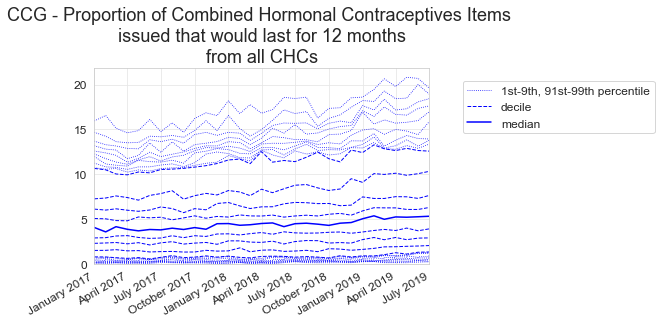

In [5]:

charts.deciles_chart(
        df_ccg,
        period_column='month',
        column='prop_twelve',
        title="CCG - Proportion of Combined Hormonal Contraceptives Items \n issued that would last for 12 months \n from all CHCs ",
        show_outer_percentiles=True)

<module 'matplotlib.pyplot' from 'C:\\Users\\bmackenna\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

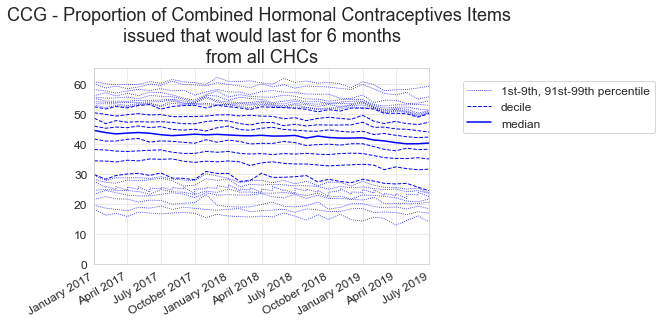

In [6]:
charts.deciles_chart(
        df_ccg,
        period_column='month',
        column='prop_six',
        title="CCG - Proportion of Combined Hormonal Contraceptives Items \n issued that would last for 6 months \n from all CHCs ",
        show_outer_percentiles=True)

<module 'matplotlib.pyplot' from 'C:\\Users\\bmackenna\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

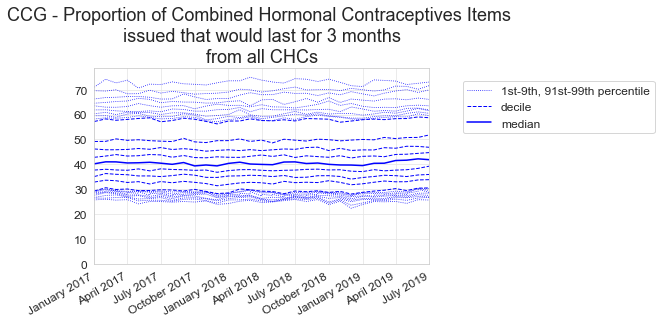

In [7]:

charts.deciles_chart(
        df_ccg,
        period_column='month',
        column='prop_three',
        title="CCG - Proportion of Combined Hormonal Contraceptives Items \n issued that would last for 3 months \n from all CHCs ",
        show_outer_percentiles=True)